<a href="https://colab.research.google.com/github/kelzheng/QC-Mentorship/blob/master/QC_Mentorship.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# QC Mentorship

In this notebook, we're exploring the solution to **Task 2** of the [QC Mentorship Tasks](https://https://docs.google.com/document/d/1lo_qy6Y7jhwBMWpQuecxAFG3L_4soYkpq0TaLq42o-A/edit):

```
Implement a circuit which returns |00> and |11> with equal probability.

*Requirements*:
* Circuit should consist only of CNOTs, RXs and RYs. 
* Start from all parameters in parametric gates being equal to 0 or randomly chosen. 
* You should find the right set of parameters using gradient descent (you might use more advanced optimization methods if you like). 
* Simulations must be done with sampling - i.e. limited number of measurements per iteration and noise. 
Compare the results for different numbers of measurements: 10, 100, 1000.

*Bonus question*: How to make sure you produce state |00>+|11> and not |00>-|11> ?
```



## 1. Setup
Here we install/import required packages. Outside of the python standard library, these include:
* [Cirq](https://https://github.com/quantumlib/Cirq): a Python library for writing, manipulating, and optimizing quantum circuits and running them against quantum computers and simulators.
* [NumPy](https://https://numpy.org/): a package for scientific computing with Python that lets us use N-dimensional array objects.

In [1]:
!pip install cirq

     |████████████████████████████████| 1.2MB 3.3MB/s 
     |████████████████████████████████| 1.8MB 38.8MB/s 
     |████████████████████████████████| 1.2MB 36.9MB/s 
     |████████████████████████████████| 5.3MB 36.8MB/s 
  Created wheel for networkx: filename=networkx-2.3-py2.py3-none-any.whl size=1556408 sha256=284f13606b2e646e92dd1d31c5f109822bc374088b90ee29dc5d6c39ccc5ea1d
  Stored in directory: /root/.cache/pip/wheels/de/63/64/3699be2a9d0ccdb37c7f16329acf3863fd76eda58c39c737af
Successfully built networkx
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: networkx 2.4
    Uninstalling networkx-2.4:
      Successfully uninstalled networkx-2.4
  Found existing installation: protobuf 3.10.0
    Uninstalling protobuf-3.10.0:
      Successfully uninstalled protobuf-3.10.0
  Found existing installation: sympy 1.1.1
    Uninstalling sympy-1.1.1:
      Successfully uninstalled sympy-1.1.1


In [0]:
# Cirq for quantum circuit creation and simulation
import cirq
from cirq.circuits import InsertStrategy
from cirq.contrib.svg import circuit_to_svg
from cirq import ops, value
# Numpy for arrays
import numpy as np
# Misc. from Python Standard Library
import random
import os
from IPython.display import SVG, display
from typing import List, Union, Sequence, Dict, Optional

## 2. Initialization

To implement a circuit which returns |00> and |11> with equal probability (a two-qubit [Bell State](https://https://en.wikipedia.org/wiki/Bell_state)), we need to create:
* two qubits: `q0`, `q1`
* a set of operations (limited to only rx, ry, and CNOT) to act on the qubits: `ops`
* inital parameters for the gates rx and ry corresponding to their theta values: `thetaRX`, `thetaRY`
* a circuit that applies the operations to the qubits: `circuit`
* a simulator that runs the circuit for a specified number of repetitions: `reps`, `simulator`

In [0]:
# Generate the qubits needed to create the two-qubit |00> and |11> states.
q0, q1 = cirq.LineQubit.range(2)
# Define parameters (theta1, theta2) with random initial guess between 0 and 2*pi (random.uniform(0,2*np.pi)) or 0. Here we'll use 0
thetaRX = 0.0
thetaRY = 0.0
thetas = np.array([[thetaRX],[thetaRY]])
# Operations, enter operations like [cirq.H(q0), cirq.H(q1), cirq.CNOT(q0, q1), cirq.H(q1)]
ops = [cirq.rx(thetaRX)(q0), cirq.ry(thetaRY)(q0), cirq.CNOT(q0,q1), cirq.measure(q0), cirq.measure(q1)]
# Define the circuit
circuit = cirq.Circuit(*ops)
# Set up the simulator
simulator = cirq.Simulator()
# Define the number of repetitions (reps[0] is 1)
reps = [1, 10, 100, 1000]

To find parameters, we'll want to re-run the circuit with different parameters, so we'll define two functions to help...
* regenerate the circuit with new parameters in ops: `generateCircuit(ops)`
* return a dataframe of results from simulating the circuit with our desired number of measurements: `simulateCircuit(circuit, reps)`

Note that in simulateCircuit, we're using Cirq's [simulator.run](https://cirq.readthedocs.io/en/stable/generated/cirq.Simulator.html) function. This returns simulation results that mimic running our circuit on actual quantum hardware. The initial state of of our circuit is taken to be 0s, and the circuit is run using specified operations applied with some amount of noise.


In [0]:
def generateCircuit(thetaRX, thetaRY): 
  ops = [cirq.rx(thetaRX)(q0), cirq.ry(thetaRY)(q0), cirq.CNOT(q0,q1), cirq.measure(q0), cirq.measure(q1)]
  circuit = cirq.Circuit(*ops)
  return circuit

def simulateCircuit(simulatedCircuit, reps):
  result = simulator.run(simulatedCircuit, repetitions=reps)
  return result

# 3. Intermediary values

Finding the appropriate parameters (`thetaRX` and `thetaRY`) for our two-qubit Bell State means finding parameters for our operations (`ops`) that give us the outcome: 
> $\frac{1}{\sqrt2}$|00⟩ + $\frac{1}{\sqrt2}$|11⟩

Our current circuit looks like this:

In [5]:
print(circuit)

0: ───Rx(0.0π)───Ry(0.0π)───@───M───
                            │
1: ─────────────────────────X───M───


### 3.1 Counts and Amplitudes

Theoretically, for any values of our parameters thetaRX and thetaRY between 0 and 2$\pi$, we'll always get some: 

> $\alpha_0$|00⟩ + $\alpha_1$|11⟩ 

(in other words, no probability of the states |01⟩ or |10⟩).

Using [Born's rule](https://en.wikipedia.org/wiki/Born_rule), we can estimate these $\alpha_0^2$ and $\alpha_1^2$ values as:

> $\alpha_i^2$ = (number of times each state was measured)/(total number of measurements), $i \epsilon (0,1)$

We'll define these as intermediary values:
* `count0`, `count1`: number of times each state |00⟩ or |11⟩ was measured, respectively
* `alpha0`, `alpha1`: squared amplitudes of each state |00⟩ or |11⟩ estimated using Born's rule described above.

Previously, we defined:
* `reps`: array with all possible total number of measurements

In [0]:
def getCount(result, reps):
  count0 = (result.data.groupby(["0", "1"]).size().reset_index(name="Count"))['Count'][0]
  count1 = reps-count0
  return count0

def getAlpha(result, reps):
  count0 = (result.data.groupby(["0", "1"]).size().reset_index(name="Count"))['Count'][0]
  count1 = reps-count0
  return count0/reps

We also know from Born's rule that:
> $\sum_{i=0}^{n}\alpha_i^2 = 1$ 

So in our case:
> `alpha1 = 1 - alpha0` and `count1 = repetitions - count0`

We want both alpha1 and alpha0 to be as close to 0.5 as possible.

### 3.2 Error and optimization problem

Because we want both alpha1 and alpha0 to be as close to 0.5 as possible, we can define some intermediary term for error using the Born's rule above as:
> `error` = |`alpha0`- 0.5 | = Y(`theta1`, `theta2`)


In [0]:
def getError(result, reps):
  count0 = (result.data.groupby(["0", "1"]).size().reset_index(name="Count"))['Count'][0]
  alpha0 = count0/reps
  error = abs(alpha0-0.5)
  return error

## 4. Solution

We want to choose some parameters `thetaRX` and `thetaRY` that minimize this error. This can be fomulated into an **optimization problem** where:
* the **cost function** is the convex function `error(alpha0) = |alpha0 - 0.5|`, where `alpha0 = f(thetaRX, thetaRY)`
* the **acceptable error**, `aerror` is some deviation of alpha0 from 0.5. We'll let `aerror = 0.005`, the current error rate for a quantum gate.

In [0]:
aerror = 0.005

One method for solving this optimization problem is using **gradient descent**. This involves the following steps:

1. Set a stepsize, `stepsize`, to change each theta by. We'll choose 10% of the range.
2. Calculate the partial derivatives of the error function (Y) with respect to theta1 and theta2 for the step size, using
  * `alphaOld = getAlpha(circuit, state, reps)`
  * regenerate the circuit with `thetaRX+stepsize`, `thetaRY`
    * `alphaNewTRX = getAlpha(circuit, state, reps)`
  * regenerate the circuit with `thetaRX`, `thetaRY+stepsize`
    * `alphaNewTRY = getAlpha(circuit, state, reps)`
  * `dyda = 1`
  * `dydtRX = dyda*(alphaNewRX-alphaOld)/stepsize`
  * `dydtRY = dyda*(alphaNewRY-alphaOld)/stepsize`
  * `delY = np.array([[dydtRX], [dydtRY]])`
3. Using gradient descent, we can iteratively reduce the value of y given some learning rate, `learningRate` as: `theta := theta - learningRate*delY`
4. Generate the circuit and calculate the error using the new thetas and continue to update until the error rate is less than the threshold `aerror`

In [0]:
# set stepsize to 1% of the range, 0.01*2*np.pi
stepsize = 0.01

# calculate the partial derivatives
def getDelY(circuit, reps, stepsize):
  # simulate previous circuit
  result = simulateCircuit(circuit, reps)
  alphaOld = getAlpha(result, reps)

  # simualte new circuit with thetaRX+stepsize, calculate alpha
  circuit = generateCircuit(thetaRX+stepsize, thetaRY)
  result = simulateCircuit(circuit, reps)
  alphaNewTRX = getAlpha(result, reps)

  # simualte new circuit with thetaRY+stepsize, calculate alpha
  circuit = generateCircuit(thetaRX, thetaRY+stepsize)
  result = simulateCircuit(circuit, reps)
  alphaNewTRY = 1-getAlpha(result, reps)

  # calculate partial derivatives
  dyda = 1
  dydtRX = dyda*(alphaNewTRX-alphaOld)/stepsize
  dydtRY = dyda*(alphaNewTRY-alphaOld)/stepsize

  # calculate delY
  delY = np.array([[dydtRX], [dydtRY]])
  return delY

# set the learning rate
learningRate = 0.01

# update thetas
def updateThetas(thetas, learningRate, delY):
  thetas -= learningRate*delY
  return thetas

### 4.1 Running the solution
To find the solution, we initialize as explained in section 1, then calculate all our itermediary values explained in section 2, then chain together all our helper functions explained in section 3 and the begining of this section.

Below is an example:

In [0]:
# Generate the qubits needed to create the two-qubit |00> and |11> states.
q0, q1 = cirq.LineQubit.range(2)
# Define parameters (theta1, theta2) with random initial guess between 0 and 2*pi random.uniform(0,2*np.pi)
thetaRX = 0.0
thetaRY = 0.0
thetas = np.array([[thetaRX],[thetaRY]])
# Operations, enter operations like [cirq.H(q0), cirq.H(q1), cirq.CNOT(q0, q1), cirq.H(q1)]
ops = [cirq.rx(thetaRX)(q0), cirq.ry(thetaRY)(q0), cirq.CNOT(q0,q1), cirq.measure(q0), cirq.measure(q1)]
# Define the circuit
circuit = cirq.Circuit(*ops)
# Set up the simulator
simulator = cirq.Simulator()
# Define the number of repetitions 1, 10, 100, or 1000
reps = 10
# Define initial result
result = simulateCircuit(circuit, reps)
# Calculate alphas
alpha0 = getAlpha(result, reps)
alpha1 = 1-alpha0

In this example, we've inialized the following circuit, with an initial simulation shown by the histogram shown below:

INITIAL CIRCUIT
StepSize =
0.01

LearningRate =
0.01

Alphas =
(1.0, 0.0)

Error =
0.5

Thetas =
0.0 0.0

Circuit =
0: ───Rx(0.0π)───Ry(0.0π)───@───M───
                            │
1: ─────────────────────────X───M───

Histogram =


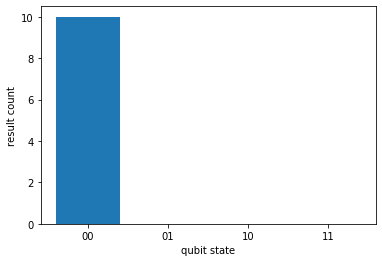

[10.  0.  0.  0.]


In [29]:
print('INITIAL CIRCUIT')

stepsize = 0.01
print('StepSize =')
print(stepsize)
print('')

learningRate = 0.01
print('LearningRate =')
print(learningRate)
print('')

alpha0 = getAlpha(result, reps)
alpha1 = 1-alpha0
alphas = (alpha0, alpha1)
print('Alphas =')
print(alphas)
print('')

error = getError(result, reps)
print('Error =')
print(error)
print('')

print('Thetas =')
print(float(thetas[0]), float(thetas[1]))
print('')

print('Circuit =')
print(circuit)
print('')

print('Histogram =')
print(cirq.plot_state_histogram(result))

In [31]:
# simulate previous circuit
  result = simulateCircuit(circuit, reps)
  # calculate previous alpha
  alphaOld = getAlpha(result, reps)
  # print(alphaOld)

  # simualte new circuit with thetaRX+stepsize, calculate alpha
  circuit = generateCircuit(thetaRX+stepsize, thetaRY)
  result = simulateCircuit(circuit, reps)
  alphaNewTRX = getAlpha(result, reps)
  # print(alphaNewTRX)

  # simualte new circuit with thetaRY+stepsize, calculate alpha
  circuit = generateCircuit(thetaRX, thetaRY+stepsize)
  result = simulateCircuit(circuit, reps)
  alphaNewTRY = 1-getAlpha(result, reps)
  # print(alphaNewTRY)

  # calculate partial derivatives
  dyda = 1
  dydtRX = dyda*(alphaNewTRX-alphaOld)/stepsize
  dydtRY = dyda*(alphaNewTRY-alphaOld)/stepsize

  # calculate delY
  delY = np.array([[dydtRX], [dydtRY]])
  # print(dydtRX, dydtRY)

1.0
1.0
0.0
0.0 -100.0


In [19]:
print(reps)

10


In [32]:
print(delY)

[[   0.]
 [-100.]]


We want both bars of the histogram to be approximately equal, so we'll run the following

In [35]:
while error > aerror:
  delY = getDelY(circuit, reps, stepsize)
  thetas = updateThetas(thetas, learningRate, delY)
  circuit = generateCircuit(float(thetas[0]), float(thetas[1]))
  result = simulateCircuit(circuit, reps)
  error = getError(result, reps)
  alpha0 = getAlpha(result, reps)
  alpha1 = 1-getAlpha(result, reps)
  alphas = (alpha0, alpha1)
  print('=============iteration============')
  print('Error =')
  print(error)
  print('Alphas =')
  print(alphas)
  print('Thetas =')
  print(float(thetas[0]), float(thetas[1]))
else:
  print('THE FINAL THETAS ARE:')
  print('thetaRX= ' + str(float(thetas[0])) + ' and thetaRY= ' + str(float(thetas[1])))
  print('This gives error = ' + str(error) + ' and alphas = ' + str(float(alphas[0])) +', ' + str(float(alphas[1])))

=============iteration============
Error =
0.19999999999999996
Alphas =
(0.7, 0.30000000000000004)
Thetas =
0.0 1.0
=============iteration============
Error =
0.19999999999999996
Alphas =
(0.7, 0.30000000000000004)
Thetas =
-0.19999999999999996 1.8
=============iteration============
Error =
0.3
Alphas =
(0.2, 0.8)
Thetas =
-0.7999999999999999 2.2
=============iteration============
Error =
0.09999999999999998
Alphas =
(0.4, 0.6)
Thetas =
-1.4 2.6
=============iteration============
Error =
0.19999999999999996
Alphas =
(0.7, 0.30000000000000004)
Thetas =
-1.9 3.1
=============iteration============
Error =
0.09999999999999998
Alphas =
(0.6, 0.4)
Thetas =
-2.2 3.8000000000000003
=============iteration============
Error =
0.09999999999999998
Alphas =
(0.6, 0.4)
Thetas =
-2.4000000000000004 4.6000000000000005
=============iteration============
Error =
0.2
Alphas =
(0.3, 0.7)
Thetas =
-2.9000000000000004 5.1000000000000005
=============iteration============
Error =
0.4
Alphas =
(0.1, 0.9)
Thet

To visualize the results, we can run the following cells:

FINAL CIRCUIT
Fraction each state occured for |00> and |11> respectively =
(0.5, 0.5)

Error =
0.0

Thetas =
-3.3000000000000003 7.7

Circuit =
0: ───Rx(-1.05π)───Ry(-1.549π)───@───M───
                                 │
1: ──────────────────────────────X───M───

Histogram =


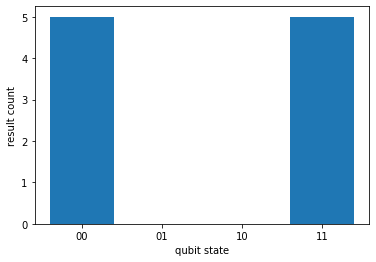

[5. 0. 0. 5.]


In [37]:
print('FINAL CIRCUIT')

alpha0 = getAlpha(result, reps)
alpha1 = getAlpha(result, reps)
alphas = (alpha0, alpha1)
print('Fraction each state occured for |00> and |11> respectively =')
print(alphas)
print('')

error = getError(result, reps)
print('Error =')
print(error)
print('')

print('Thetas =')
print(float(thetas[0]), float(thetas[1]))
print('')

print('Circuit =')
print(circuit)
print('')

print('Histogram =')
print(cirq.plot_state_histogram(result))

## 5. Comparing effect of multiple repetitions of the simulation
To compare the results for different numbers of measurements: 1, 10, 100, 1000, we can run our solution with reps equal to the four different values and compare the theta values obtained.

In [0]:
# Initialize
# Generate the qubits needed to create the two-qubit |00> and |11> states.
q0, q1 = cirq.LineQubit.range(2)
# Define parameters (theta1, theta2) with random initial guess between 0 and 2*pi
thetaRX = 0.0
thetaRY = 0.0
thetas = np.array([[thetaRX],[thetaRY]])
# Operations, enter operations like [cirq.H(q0), cirq.H(q1), cirq.CNOT(q0, q1), cirq.H(q1)]
ops = [cirq.rx(thetaRX)(q0), cirq.ry(thetaRY)(q0), cirq.CNOT(q0,q1), cirq.measure(q0), cirq.measure(q1)]
# Define the circuit
initialCircuit = cirq.Circuit(*ops)
# Set up the simulator
simulator = cirq.Simulator()
# Define parameters
stepsize = 0.01
learningRate = 0.01
aerror = 0.005
error = 10^6

In [0]:
def optimizeThetas(error, aerror, circuit, reps, thetas, stepsize):
  while error > aerror:
    delY = getDelY(circuit, reps, stepsize)
    thetas = updateThetas(thetas, learningRate, delY)
    circuit = generateCircuit(float(thetas[0]), float(thetas[1]))
    result = simulateCircuit(circuit, reps)
    error = getError(result, reps)
    alpha0 = getAlpha(result, reps)
    alpha1 = 1-alpha0
    alphas = (alpha0, alpha1)
    print('=============iteration============')
    print('Error =')
    print(error)
    print('Alphas =')
    print(alphas)
    print('Thetas =')
    print(float(thetas[0]), float(thetas[1]))
  else:
    print('THE FINAL THETAS ARE:')
    print('thetaRX= ' + str(float(thetas[0])) + ' and thetaRY= ' + str(float(thetas[1])) + ' and alphas = ' + str(float(alphas[0])) +', ' + str(float(alphas[1])))
    print('This gives error = ' + str(error))
    return(float(thetas[0]), float(thetas[1]), error)

In [40]:
allReps = [10, 100, 1000]
allThetas = []
allErrors = []

for reps in allReps:
  # Initialize
  # Generate the qubits needed to create the two-qubit |00> and |11> states.
  q0, q1 = cirq.LineQubit.range(2)
  # Define parameters (theta1, theta2) with random initial guess between 0 and 2*pi
  thetaRX = 0.0
  thetaRY = 0.0
  thetas = np.array([[thetaRX],[thetaRY]])
  # Operations, enter operations like [cirq.H(q0), cirq.H(q1), cirq.CNOT(q0, q1), cirq.H(q1)]
  ops = [cirq.rx(thetaRX)(q0), cirq.ry(thetaRY)(q0), cirq.CNOT(q0,q1), cirq.measure(q0), cirq.measure(q1)]
  # Define the circuit
  circuit = cirq.Circuit(*ops)
  # Set up the simulator
  simulator = cirq.Simulator()
  # Define parameters
  stepsize = 0.1*2*np.pi
  learningRate = 0.01
  aerror = 0.005
  error = 10^6
  print(reps)
  (theta1, theta2, error) = optimizeThetas(error, aerror, circuit, reps, thetas, stepsize)
  storedThetas=(theta1, theta2)
  allThetas.append(storedThetas)
  allErrors.append(error)


10
=============iteration============
Error =
0.5
Alphas =
(1.0, 0.0)
Thetas =
0.0047746482927568615 0.014323944878270581
=============iteration============
Error =
0.5
Alphas =
(1.0, 0.0)
Thetas =
0.006366197723675814 0.027056340325622208
=============iteration============
Error =
0.5
Alphas =
(1.0, 0.0)
Thetas =
0.006366197723675814 0.042971834634811745
=============iteration============
Error =
0.5
Alphas =
(1.0, 0.0)
Thetas =
0.00954929658551372 0.057295779513082325
=============iteration============
Error =
0.5
Alphas =
(1.0, 0.0)
Thetas =
0.012732395447351625 0.07002817496043395
=============iteration============
Error =
0.5
Alphas =
(1.0, 0.0)
Thetas =
0.01591549430918953 0.08276057040778559
=============iteration============
Error =
0.5
Alphas =
(1.0, 0.0)
Thetas =
0.01591549430918953 0.09708451528605617
=============iteration============
Error =
0.5
Alphas =
(1.0, 0.0)
Thetas =
0.014323944878270578 0.11140846016432676
=============iteration============
Error =
0.5
Alphas =
(1.

In [41]:
allThetas

[(-0.03501408748021699, 1.2286761606694334),
 (-0.18477888892969055, 1.4715466038276641),
 (-0.2501279085632228, 1.539060130687247)]

Trying the thetas obtained in a quantum simulator with no noise gives the state as:

In [0]:
def generateCircuitNoMeasurement(thetaRX, thetaRY): 
  ops = [cirq.rx(thetaRX)(q0), cirq.ry(thetaRY)(q0), cirq.CNOT(q0,q1)]
  circuit = cirq.Circuit(*ops)
  return circuit

In [47]:
# Generate circuits with the thetas
circuit10 = generateCircuitNoMeasurement(allThetas[0][0], allThetas[0][1])
circuit100 = generateCircuitNoMeasurement(allThetas[1][0], allThetas[1][1])
circuit1000 = generateCircuitNoMeasurement(allThetas[2][0], allThetas[2][1])

# Simulate the circuits with no noise
result10 = simulator.simulate(circuit10)
result100 = simulator.simulate(circuit100)
result1000 = simulator.simulate(circuit1000)

# Get the state in Dirac notation
print(result10.dirac_notation())
print(result100.dirac_notation())
print(result1000.dirac_notation())

(0.82-0.01j)|00⟩ + (0.58+0.01j)|11⟩
(0.74-0.06j)|00⟩ + (0.67+0.07j)|11⟩
(0.71-0.09j)|00⟩ + (0.69+0.09j)|11⟩


Comparing each circuit state before measurement using the Dirac notation, we can see that the resultant thetas are closer to our desired 0.71|00⟩ + 0.71|11⟩ as measurements increase.

Using these results, we can implement circuit which returns |00> and |11> with equal probability as an RX and RY gate with a theta of any multiple of pi/2.

In [56]:
# Generate the qubits needed to create the two-qubit |00> and |11> states.
q0, q1 = cirq.LineQubit.range(2)
# Define parameters (theta1, theta2) with random initial guess between 0 and 2*pi (random.uniform(0,2*np.pi)) or 0. Here we'll use 0
thetaRX = np.pi/2
thetaRY = np.pi/2
thetas = np.array([[thetaRX],[thetaRY]])
# Operations, enter operations like [cirq.H(q0), cirq.H(q1), cirq.CNOT(q0, q1), cirq.H(q1)]
ops = [cirq.rx(thetaRX)(q0), cirq.ry(thetaRY)(q0), cirq.CNOT(q0,q1)]
# Define the circuit
circuit = cirq.Circuit(*ops)
# Print the circuit
print(circuit)

0: ───Rx(0.5π)───Ry(0.5π)───@───
                            │
1: ─────────────────────────X───
